# Variational Monte Carlo
### For a 4 Particle System

In [ ]:
import numpy as np
import random
import math
from matplotlib import pyplot as plt
from IPython.display import clear_output


from pdb import set_trace

In [ ]:
# 1 is up and 0 is down
# these are all the possible ground configurations that might
# contribute to the ground states

# this version makes it readable
states = np.asarray([
    [1, 1, 0, 0],
    [0, 0, 1, 1],
    [1, 0, 1, 0],
    [0, 1, 0, 1],
    [1, 0, 0, 1],
    [0, 1, 1, 0],
])

# this line turns all the 0s to -1s for computational purposes
states = states*2 - 1; states

In [ ]:
def get_random_state():
    return random.choice(states)

In [382]:
def get_variational_projection(state, alpha):
    """
    This function computes the projection of state in the spin basis
    onto the varitional wave function
    """
    exponent = 0 
    # FOO DO WE COUNT THE SUMS TWICE?
    for i in range(len(state)):
        for j in range(len(state)):
            if i is not j:
                new_exp_term = -1*(alpha/(min(abs(i-j),abs((i-len(state)) - j), abs(i - (j-len(state)) )))**2)*state[i]*state[j]/4 # need the "/4" because spin 1/2 particles
                exponent += new_exp_term
    return math.exp(exponent)

In [383]:
def get_off_diagonal_configurations(state):
    """
    This function generates a list of configurations that could
    be flipped into the inputted by state by the application of
    Raising or lowering operators (Check the hamiltonian equation)
    
    returns a list of configurations
    
    ***NOTE: This solution is computational intractable and might not
    be the most optimal one
    """
    state_copy = state.copy()
    off_diagonal_configurations = list()
    for i in range(len(state)):
        if i == len(state) - 1:
            if state[i] != state[0]:
                state_copy[i] *= -1
                state_copy[0] *= -1
                off_diagonal_configurations.append(state_copy)
            return off_diagonal_configurations
        if state[i] != state[i+1]:
            state_copy[i] *= -1
            state_copy[i+1] *= -1
            off_diagonal_configurations.append(state_copy)
            state_copy = state.copy()

In [384]:
def calculate_local_energy(state, alpha):
    """
    This function calculates the local energy of a state
    """
    # contribution from Z direction spin terms
    energy = 0
    variational_projection = get_variational_projection(state, alpha) # (The 1 is the h-bar, which is one in our units)
    for i in range(len(state)):
        if i == len(state) - 1:
            energy += (variational_projection*state[i] * state[0])/4
        else:
            energy += (variational_projection*state[i] * state[i+1])/4
    # print(f"Diagonal energy: {energy}")
            
    # contributions from off diagonal terms
    non_diagonal_energies = 0
    for configuration_state in get_off_diagonal_configurations(state):
        non_diagonal_energies += get_variational_projection(configuration_state, alpha)*(1/8)
    energy += non_diagonal_energies
    # print(f"Non-Diagonal energies: {non_diagonal_energies}")
    # print(f"Variational  Projection: {variational_projection}")
    return energy / variational_projection

In [385]:
calculate_local_energy(states[2], alpha=1)

-0.888434919925785

In [386]:
def compute_R(trial_state, initial_state, alpha):
    """
    Function compute "R", which is the ratio between the weight functions
    of the initial state and the trial state.
    """
    numerator = get_variational_projection(trial_state, alpha) **2
    denominator = get_variational_projection(initial_state, alpha) **2
    return numerator / denominator

In [387]:
def random_flip(state):
    """
    Randomly flips two bits of a state such
    that there are still two up and two down
    """
    choices = random.sample(list(range(0,len(state))), len(state))
    flip1_index = choices.pop()
    flip1_value = state[flip1_index]
    state[flip1_index] *= -1
    cont = True
    while(cont):
        flip2_index = choices.pop()
        if state[flip2_index] != flip1_value:
            state[flip2_index] *= -1
            cont = False
    return state

In [388]:
def monte_carlo_estimation(alpha, num_steps):
    x_initial = get_random_state()
    running_total = 0
    for i in range(num_steps):
        x_trial = random_flip(x_initial.copy())
        R = compute_R(x_trial, x_initial, alpha)
        r = random.uniform(0,1)
        if R > r:
            x_initial = x_trial.copy()
        running_total += calculate_local_energy(x_initial, alpha)
    return running_total / num_steps

In [389]:
def get_optimal_alpha(alphas, num_steps=50000):
    energies = list()
    for i, alpha in enumerate(alphas):
        clear_output(wait=True)
        print(f"Alpha: {i+1}/{len(alphas)}")
        energies.append(monte_carlo_estimation(alpha, num_steps))
    return alphas[np.argmin(energies)], np.argmin(energies), energies

In [390]:
alphas

[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

Alpha: 9/9


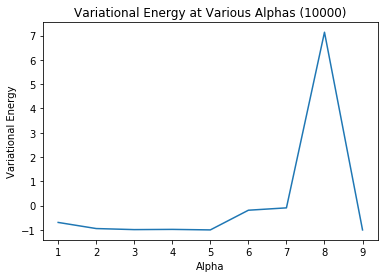

Optimal Alpha found at 9
Minimum Energy: -0.9999993145205144


In [391]:
alphas = [i*1 for i in range(1,10)]
num_steps = 10000

optimal_alpha, index, energies = get_optimal_alpha(alphas, num_steps=num_steps)

plt.plot(alphas, energies)
plt.ylabel("Variational Energy")
plt.xlabel("Alpha")
plt.title(f"Variational Energy at Various Alphas ({num_steps})")
plt.show()
print(f"Optimal Alpha found at {optimal_alpha}")
print(f"Minimum Energy: {energies[index]}")

Alpha: 9/9


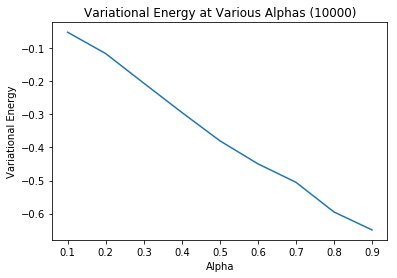

Optimal Alpha found at 0.9
Minimum Energy: -0.649294151268679


In [392]:
alphas = [i*0.1 for i in range(1,10)]
num_steps = 10000
optimal_alpha, index, energies = get_optimal_alpha(alphas, num_steps=num_steps)

plt.plot(alphas, energies)
plt.ylabel("Variational Energy")
plt.xlabel("Alpha")
plt.title(f"Variational Energy at Various Alphas ({num_steps})")
plt.show()
print(f"Optimal Alpha found at {optimal_alpha}")
print(f"Minimum Energy: {energies[index]}")

Alpha: 9/9


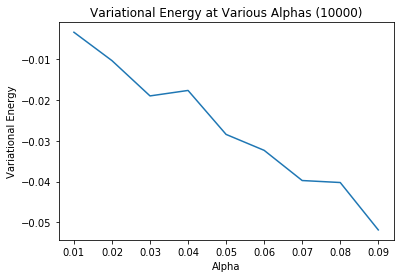

Optimal Alpha found at 0.09
Minimum Energy: -0.051877747529220086


In [393]:
alphas = [i*0.01 for i in range(1,10)]
num_steps = 10000
optimal_alpha, index, energies = get_optimal_alpha(alphas, num_steps=num_steps)

plt.plot(alphas, energies)
plt.ylabel("Variational Energy")
plt.xlabel("Alpha")
plt.title(f"Variational Energy at Various Alphas ({num_steps})")
plt.show()
print(f"Optimal Alpha found at {optimal_alpha}")
print(f"Minimum Energy: {energies[index]}")

In [ ]:
alphas = [i*1 for i in range(8,16)]
num_steps = 10000
optimal_alpha, index, energies = get_optimal_alpha(alphas, num_steps=num_steps)

plt.plot(alphas, energies)
plt.ylabel("Variational Energy")
plt.xlabel("Alpha")
plt.title(f"Variational Energy at Various Alphas ({num_steps})")
plt.show()
print(f"Optimal Alpha found at {optimal_alpha}")
print(f"Minimum Energy: {energies[index]}")

Alpha: 1/8


In [ ]:
states[0]

In [ ]:
get_off_diagonal_configurations(states[2])

In [ ]:
-2*math.exp(float(1.5))

## This one is without translational invariance

In [375]:
def get_variational_projection(state, alpha):
    """
    This function computes the projection of state in the spin basis
    onto the varitional wave function
    """
    exponent = 0 
    # FOO DO WE COUNT THE SUMS TWICE?
    for i in range(len(state)):
        for j in range(len(state)):
            if i is not j:
                new_exp_term = -1*(alpha/(abs(i-j))*state[i]*state[j])/4 # need the "/4" because spin 1/2 particles
                exponent += new_exp_term
    return math.exp(exponent)

In [380]:
def get_off_diagonal_configurations(state):
    """
    This function generates a list of configurations that could
    be flipped into the inputted by state by the application of
    Raising or lowering operators (Check the hamiltonian equation)
    
    returns a list of configurations
    
    ***NOTE: This solution is computational intractable and might not
    be the most optimal one
    """
    state_copy = state.copy()
    off_diagonal_configurations = list()
    for i in range(len(state)):
        if i == len(state) - 1:
            return off_diagonal_configurations
        if state[i] != state[i+1]:
            state_copy[i] *= -1
            state_copy[i+1] *= -1
            off_diagonal_configurations.append(state_copy)
            state_copy = state.copy()

Alpha: 12/12


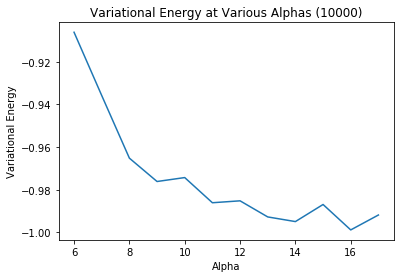

Optimal Alpha found at 16
Minimum Energy: -0.9987929984345457


In [381]:
alphas = [i*1 for i in range(6,18)]
num_steps = 10000
optimal_alpha, index, energies = get_optimal_alpha(alphas, num_steps=num_steps)

plt.plot(alphas, energies)
plt.ylabel("Variational Energy")
plt.xlabel("Alpha")
plt.title(f"Variational Energy at Various Alphas ({num_steps})")
plt.show()
print(f"Optimal Alpha found at {optimal_alpha}")
print(f"Minimum Energy: {energies[index]}")